STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

# ADALINE with Stochastic Gradient Descent (Minibatch)

![](figures/adaline-concept.png)

In this notebook, we are implementing ADALINE "by hand" without using PyTorch's autograd capabilities. In Lecture 06, we will use "automatic differentiation" (also known as "autodiff"; or autograd in PyTorch) to implement Adaline more compactly. (The reason why we don't use autodiff here is that it is useful to understand what's going on under the hood.) 

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline


## Load & Prepare a Toy Dataset

In [420]:
df = pd.read_csv('ENB2012_data.csv', index_col=False)
df.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2']
df['Y2'] = df['Y2'].apply(lambda x: 0 if x <= 30 else 1) # Binarizing the class labels???
df.tail()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
763,0.64,784.0,343.0,220.5,3.5,5,0.4,5,17.88,0
764,0.62,808.5,367.5,220.5,3.5,2,0.4,5,16.54,0
765,0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,0
766,0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,0
767,0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,0


In [421]:
pd.set_option("display.max_rows", None)
print(df)

       X1     X2     X3      X4   X5  X6    X7  X8     Y1  Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.00   0  15.55   0
1    0.98  514.5  294.0  110.25  7.0   3  0.00   0  15.55   0
2    0.98  514.5  294.0  110.25  7.0   4  0.00   0  15.55   0
3    0.98  514.5  294.0  110.25  7.0   5  0.00   0  15.55   0
4    0.90  563.5  318.5  122.50  7.0   2  0.00   0  20.84   0
5    0.90  563.5  318.5  122.50  7.0   3  0.00   0  21.46   0
6    0.90  563.5  318.5  122.50  7.0   4  0.00   0  20.71   0
7    0.90  563.5  318.5  122.50  7.0   5  0.00   0  19.68   0
8    0.86  588.0  294.0  147.00  7.0   2  0.00   0  19.50   0
9    0.86  588.0  294.0  147.00  7.0   3  0.00   0  19.95   0
10   0.86  588.0  294.0  147.00  7.0   4  0.00   0  19.34   0
11   0.86  588.0  294.0  147.00  7.0   5  0.00   0  18.31   0
12   0.82  612.5  318.5  147.00  7.0   2  0.00   0  17.05   0
13   0.82  612.5  318.5  147.00  7.0   3  0.00   0  17.41   0
14   0.82  612.5  318.5  147.00  7.0   4  0.00   0  16.95   0
15   0.8

In [503]:
# Assign features and target

X = torch.tensor(df[['X5', 'X6']].values, dtype=torch.float)
y = torch.tensor(df['Y2'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]
percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]
# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma

X_test = (X_test - mu) / sigma
torch.set_printoptions(profile="full")

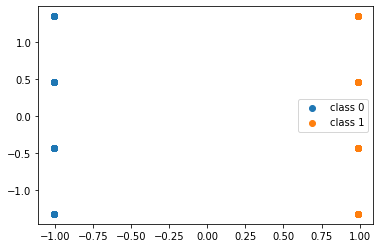

In [504]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 1')
plt.legend()
plt.show()

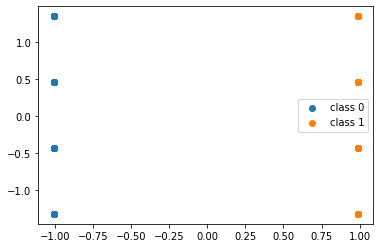

In [505]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.legend()
plt.show()

<br>
<br>

## Implement ADALINE Model

In [506]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(y - yhat)
        
        grad_yhat_weights = -x
        grad_yhat_bias = -1.
        
        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

## Define Training and Evaluation Functions

In [507]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

## Train Model

In [514]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=50,
             learning_rate=0.1,
             seed=123,
             minibatch_size=15)

    Minibatch MSE: 0.533
    Minibatch MSE: 0.340
    Minibatch MSE: 0.208
    Minibatch MSE: 0.195
    Minibatch MSE: 0.163
    Minibatch MSE: 0.180
    Minibatch MSE: 0.148
    Minibatch MSE: 0.106
    Minibatch MSE: 0.075
    Minibatch MSE: 0.140
    Minibatch MSE: 0.154
    Minibatch MSE: 0.105
    Minibatch MSE: 0.181
    Minibatch MSE: 0.075
    Minibatch MSE: 0.126
    Minibatch MSE: 0.096
    Minibatch MSE: 0.058
    Minibatch MSE: 0.121
    Minibatch MSE: 0.116
    Minibatch MSE: 0.094
    Minibatch MSE: 0.128
    Minibatch MSE: 0.063
    Minibatch MSE: 0.184
    Minibatch MSE: 0.086
    Minibatch MSE: 0.137
    Minibatch MSE: 0.157
    Minibatch MSE: 0.135
    Minibatch MSE: 0.125
    Minibatch MSE: 0.101
    Minibatch MSE: 0.145
    Minibatch MSE: 0.108
    Minibatch MSE: 0.080
    Minibatch MSE: 0.156
    Minibatch MSE: 0.083
    Minibatch MSE: 0.140
    Minibatch MSE: 0.064
    Minibatch MSE: 0.096
    Minibatch MSE: 0.060
    Minibatch MSE: 0.076
    Minibatch MSE: 0.054


### Plot Loss (MSE)

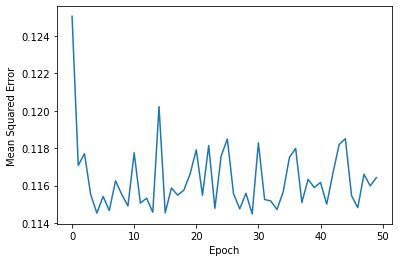

In [515]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

### Compare with analytical solution

In [516]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[ 0.3337],
        [-0.0302]])
Bias tensor([0.3397])


In [517]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train.float())
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[0.3262],
        [0.0119]])
Analytical bias tensor([0.3290])


## Evaluate on Evaluation Metric (Prediction Accuracy)

In [518]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 82.41
Test Accuracy: 85.71


## Decision Boundary

C:\PythonEnvs\venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\PythonEnvs\venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


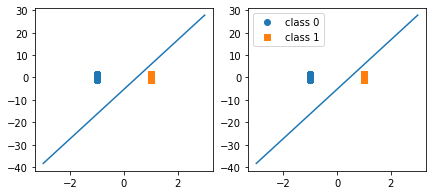

In [519]:
##########################
### 2D Decision Boundary
##########################

w, b = model.weights, model.bias - 0.5

x_min = -3
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 3
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()